# Ejercicio 1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import lfilter, periodogram, freqz, correlate
import soundfile as sf
from scipy.fft import fft
from scipy.signal import freqz, lfilter
import sounddevice as sd



Se dispone del archivo “data.py” que contiene los diccionarios con los
coeficientes “coef b” y “coef a” del proceso AR (P = 20) que modela cada uno de los audios
provistos.

In [ ]:
fs = 14700
#asumimos procesos estacionarios
colors = ['#1D452E', '#3685B5', '#73A580', '#3BA99C', '#7EBCE6']

audios_vocales = ['a.wav', 'e.wav', 'i.wav', 'o.wav', 'u.wav']
audios_consonantes = ['f.wav', 's.wav', 'j.wav', 'sh.wav']


from data import coef_a, coef_b
fonemas = ['a', 'e', 'i', 'o', 'u', 'sh', 'f', 's', 'j']

N = int(0.2 * fs) #muestras q corresponden a los 200ms

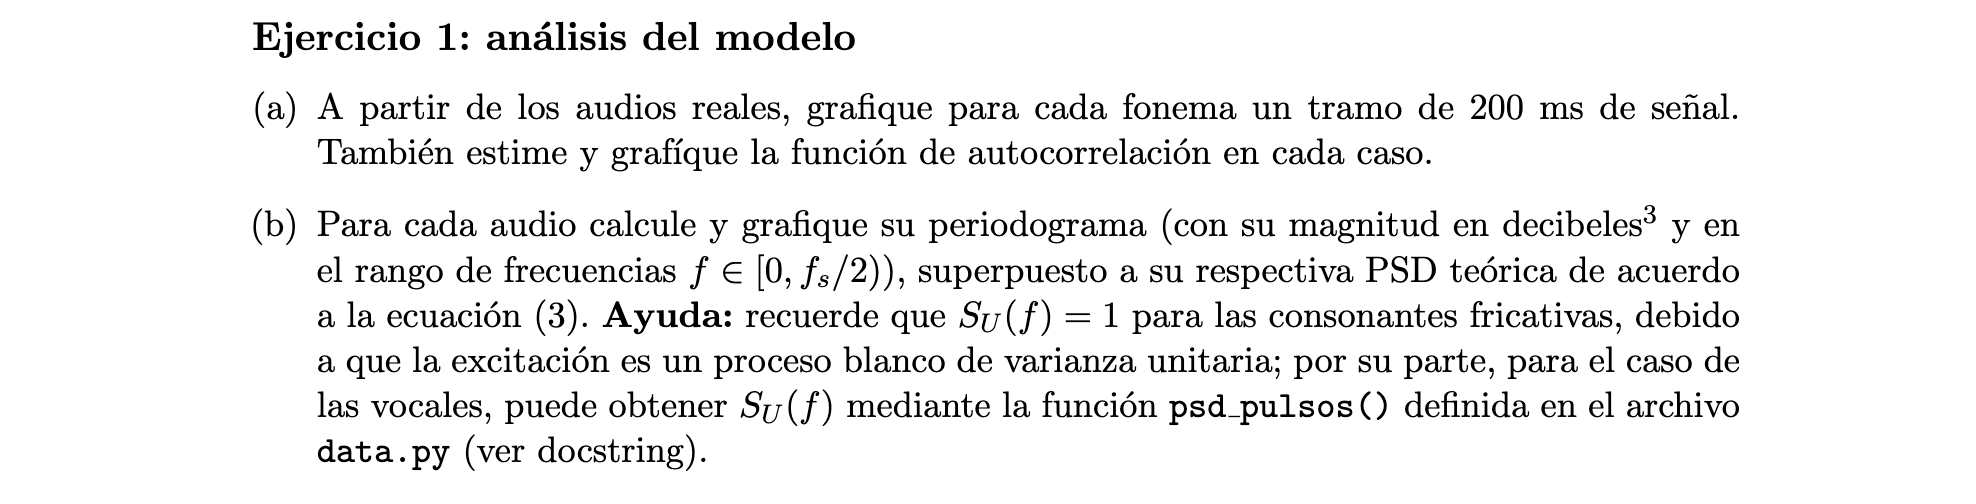

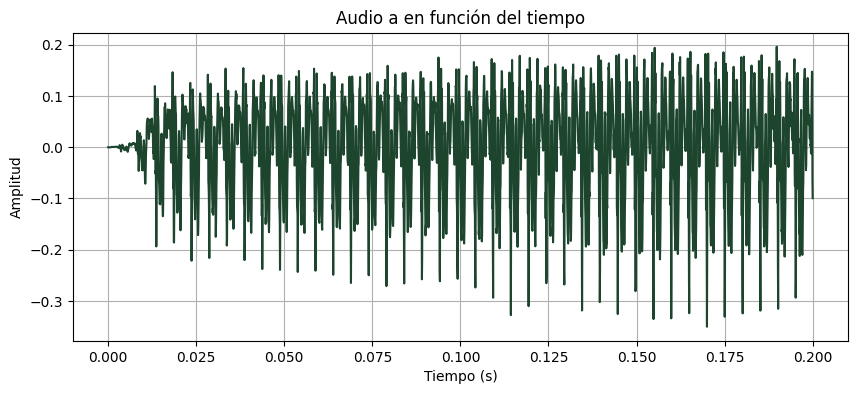

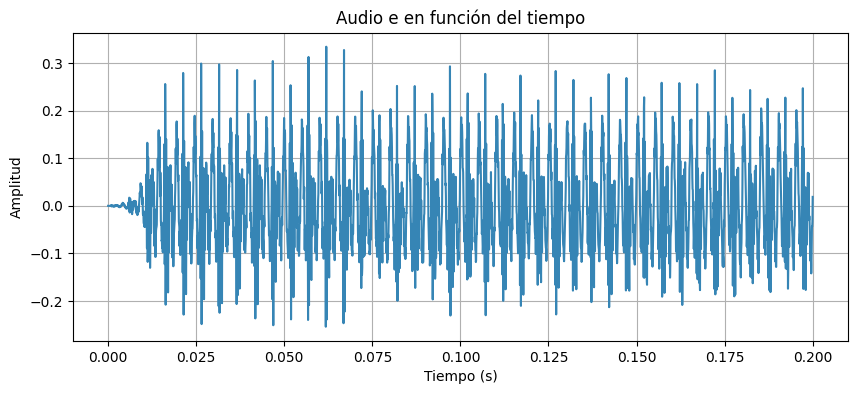

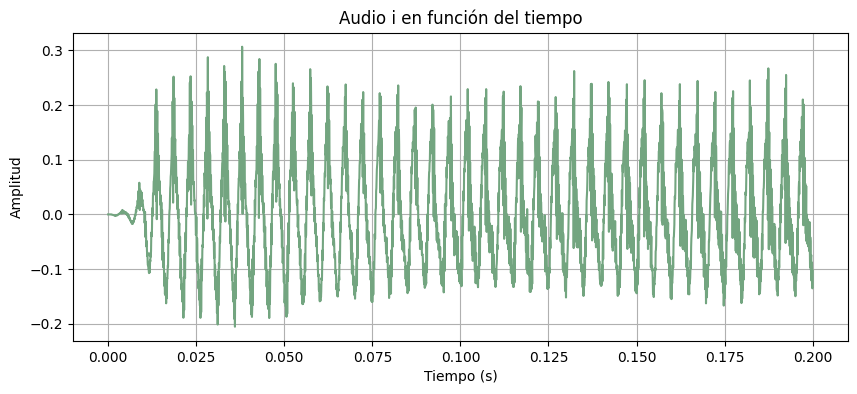

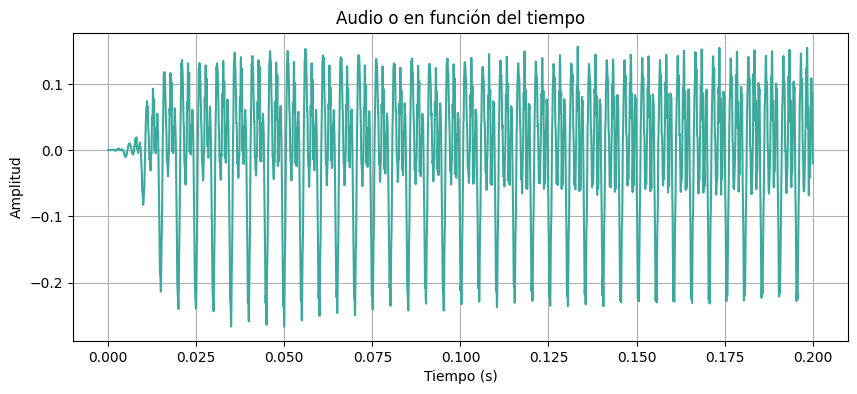

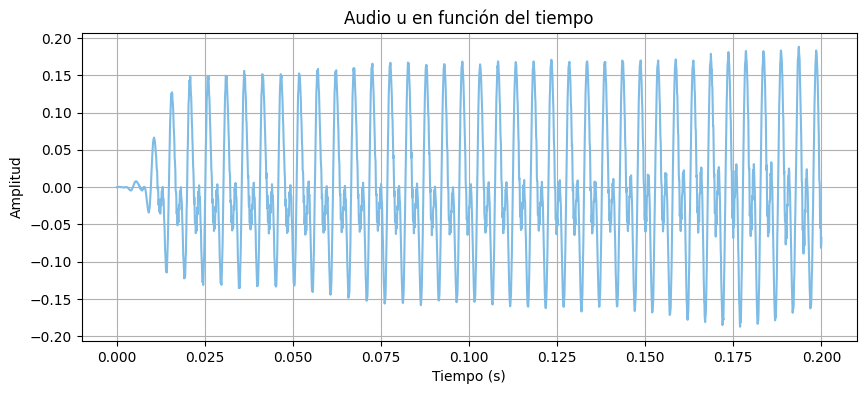

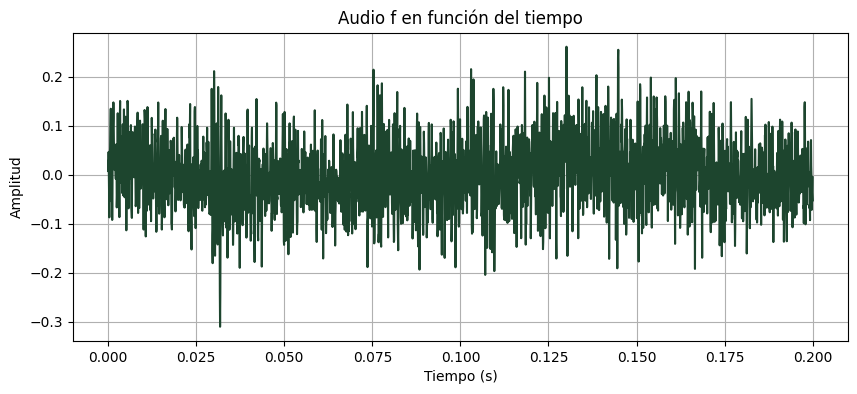

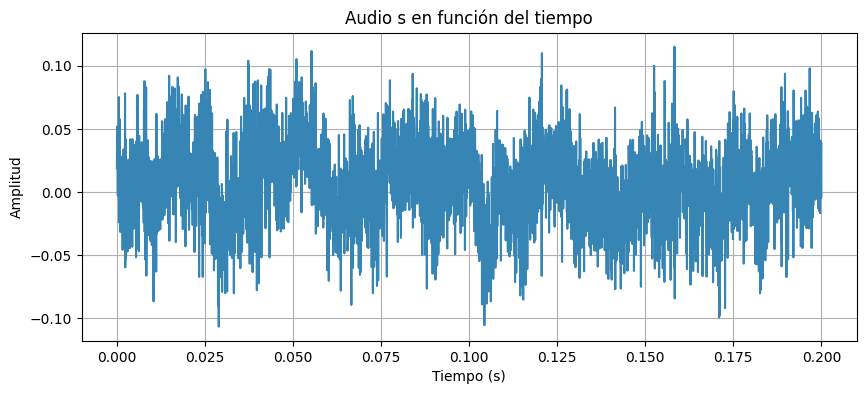

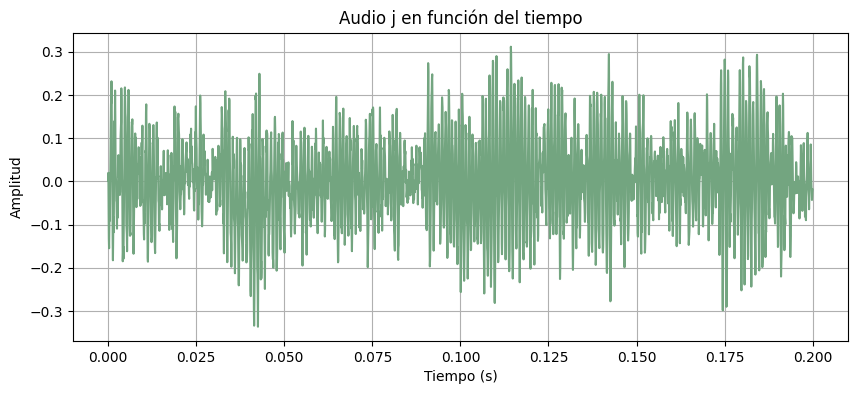

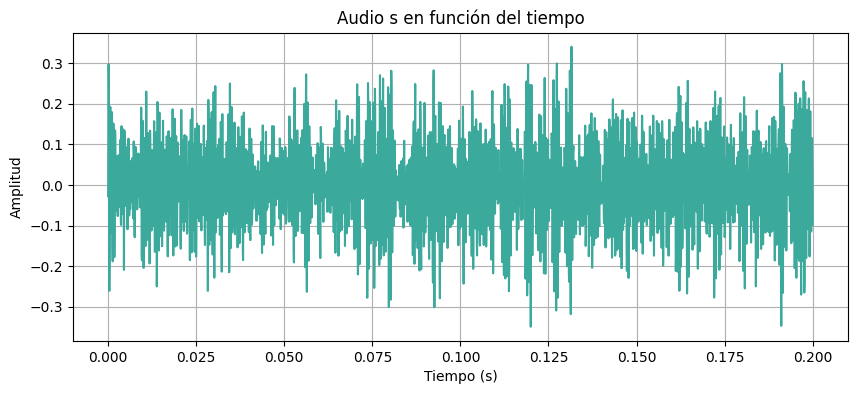

In [ ]:
#a) graficar fonemas
tramos = []
audios = []
for idx,i in enumerate(audios_vocales + audios_consonantes):
    audio, _ = sf.read(i)
    audios.append(audio)

    tramo = audio[:N]
    tramos.append(tramo)
    time = np.linspace(0, 0.2, len(tramo))

    plt.figure(figsize=(10, 4))

    plt.plot(time, tramo, colors[idx % len(colors)])
    plt.title(f"Audio {i[0]} en función del tiempo")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.grid()
    plt.show()

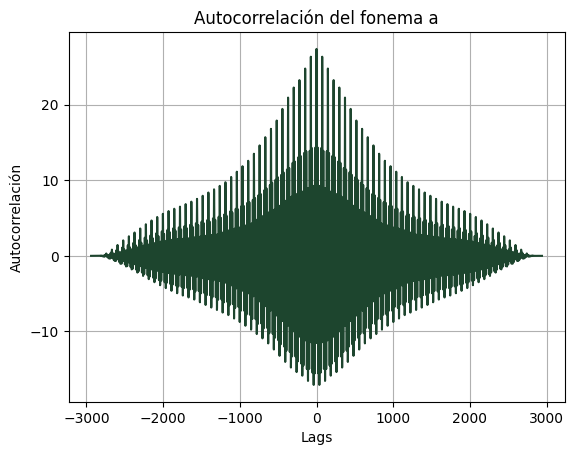

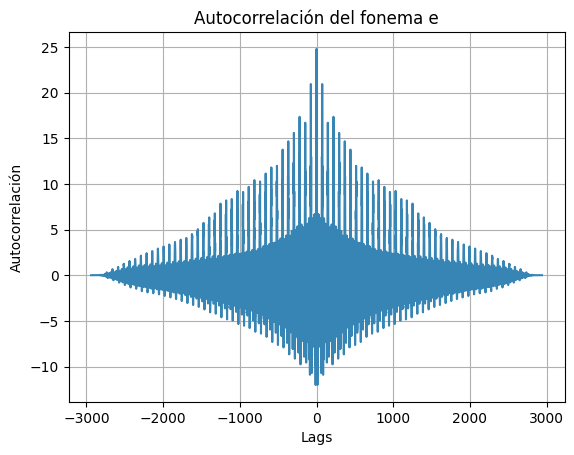

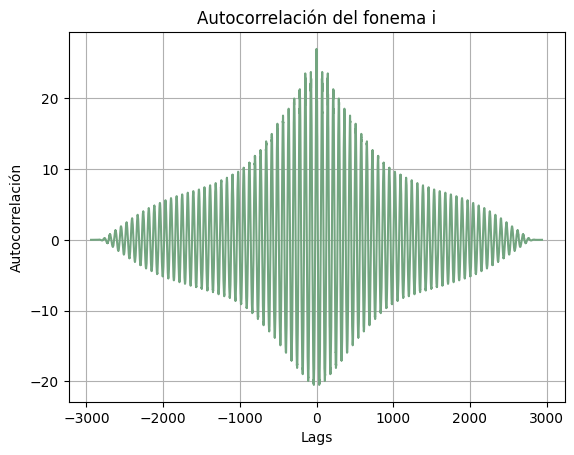

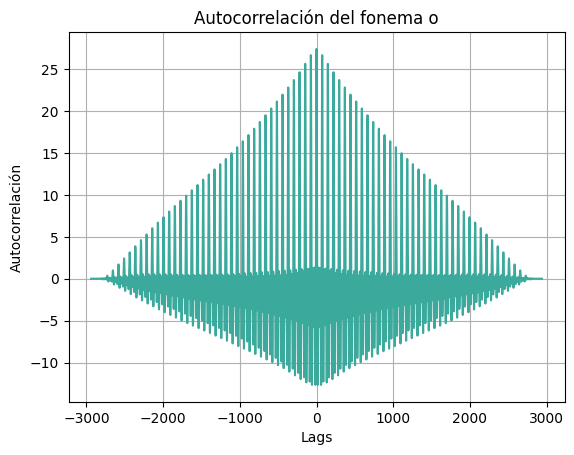

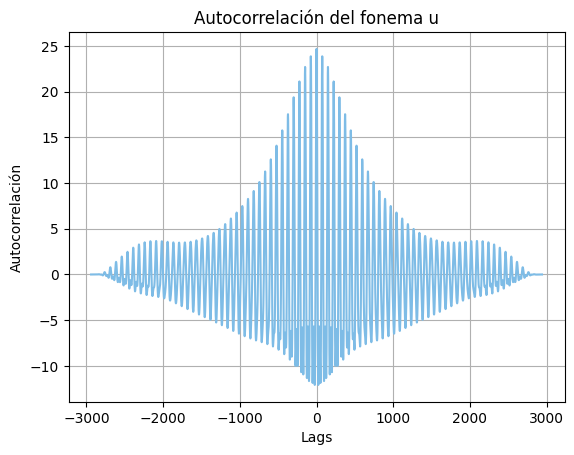

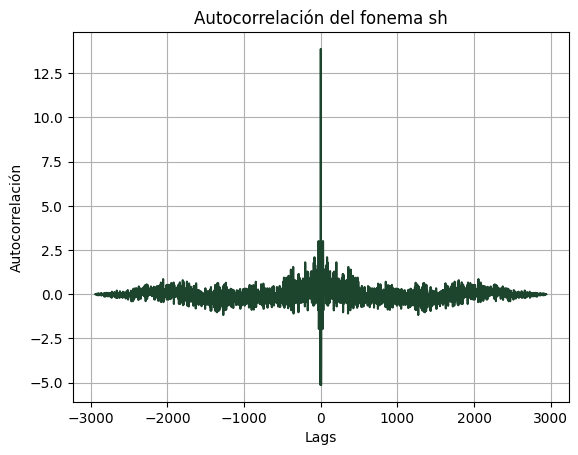

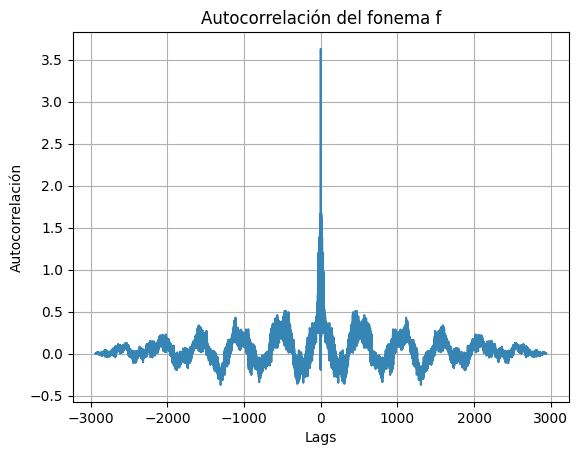

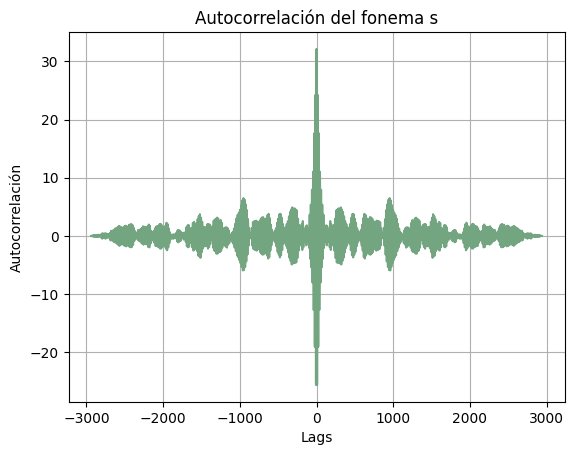

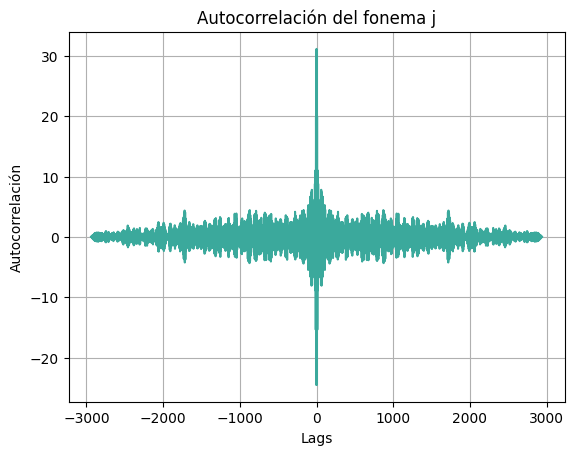

In [ ]:
#a) estimar + graficar autocorr

def graficar_autocorrelacion(tramo, fonema, color):
    autocorrelacion = correlate(tramo, tramo, mode='full')
    lags = np.arange(-len(tramo) + 1, len(tramo))
    plt.plot(lags, autocorrelacion, color)
    plt.title(f"Autocorrelación del fonema {fonema}")
    plt.xlabel("Lags")
    plt.ylabel("Autocorrelación")
    plt.grid()
    plt.show()


for i in range(len(fonemas)):
    graficar_autocorrelacion(tramos[i], fonemas[i], colors[i % len(colors)])


----------------------------------------------------------------------

In [ ]:
#pego el código xq tuve problemas importandolo

def gen_pulsos(f0, N, fs):
    """
    Genera un tren de impulsos periodico en el tiempo.
    f0: frecuencia fundamental (pitch) del tren de impulsos [Hz].
    N: cantidad de puntos que posee el array de la secuencia generada.
    fs: frecuencia de muestreo [Hz].
    Retorna: tren de impulsos (con varianza normalizada) de frecuencia f0.
    """
    s = np.zeros(N)
    s[np.arange(N) % round(fs / f0) == 0] = np.sqrt(fs / f0)
    return s

def psd_pulsos(f0, N, fs):
    """
    Genera la densidad espectral de potencia de un tren de impulsos.
    f0: frecuencia fundamental [Hz] (pitch) del tren de impulsos en el tiempo.
    N: cantidad de puntos que posee el array de la PSD resultante (SU(w)).
    fs: frecuencia de muestreo [Hz].
    Retorna:
    - PSD del tren de impulsos
    - Vector de frecuencias del espectro [Hz]
    """
    u = gen_pulsos(f0, N, fs)
    f = np.arange(N) * fs /N    # Vector de frecuencias (Hz)
    Su = np.abs(fft(u))**2 / N  # Periodograma
    return Su, f

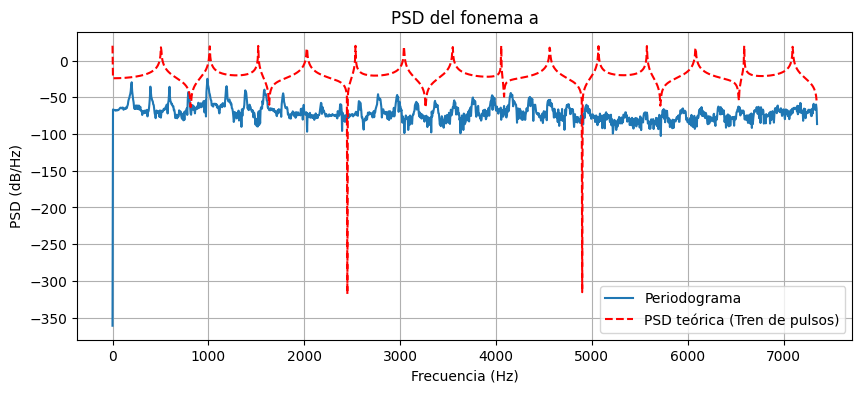

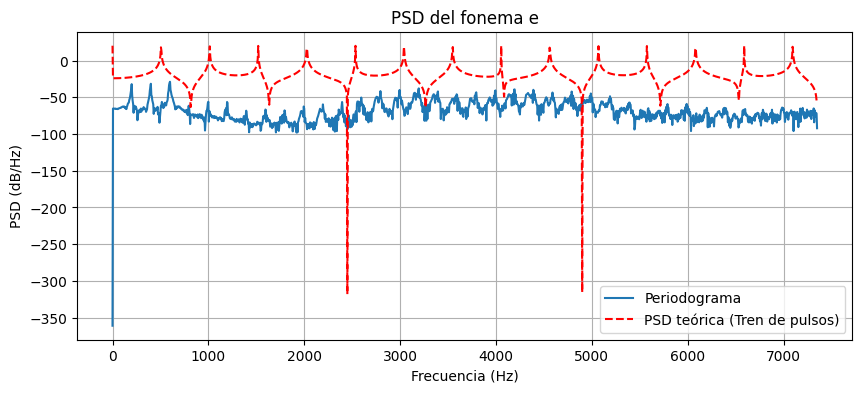

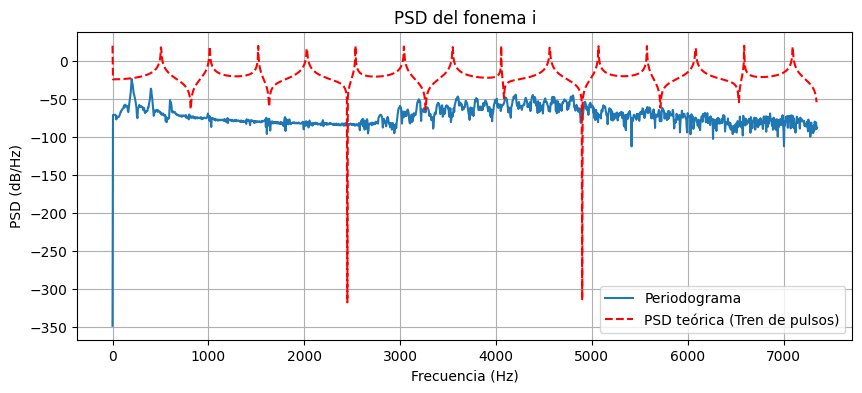

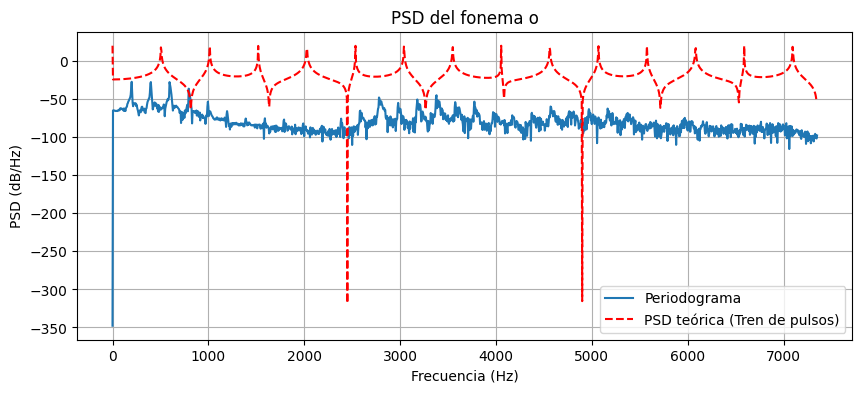

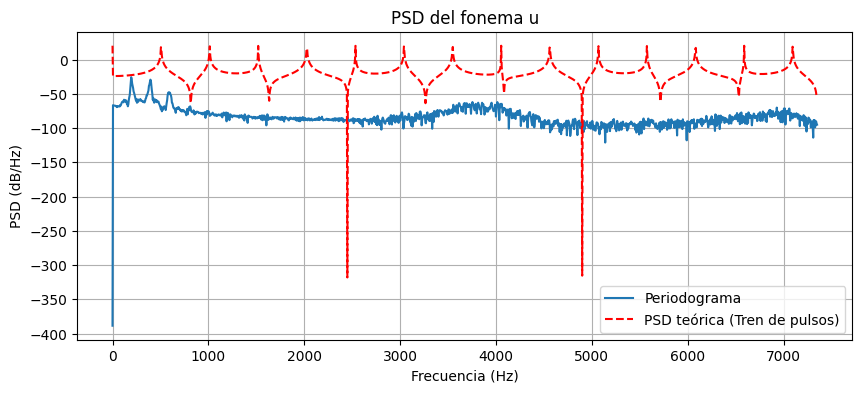

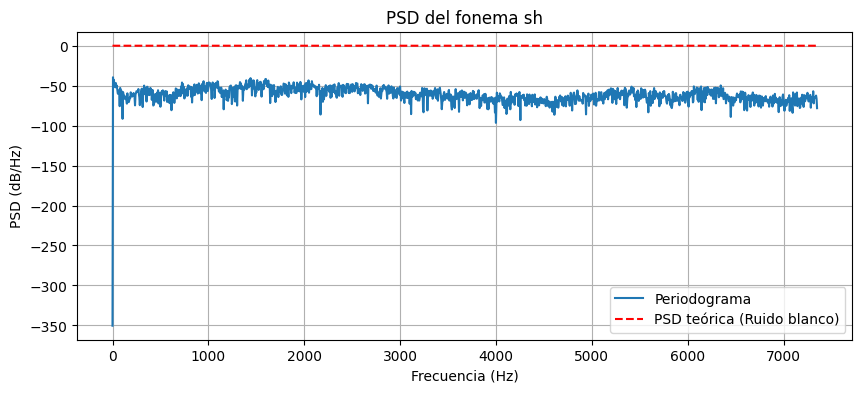

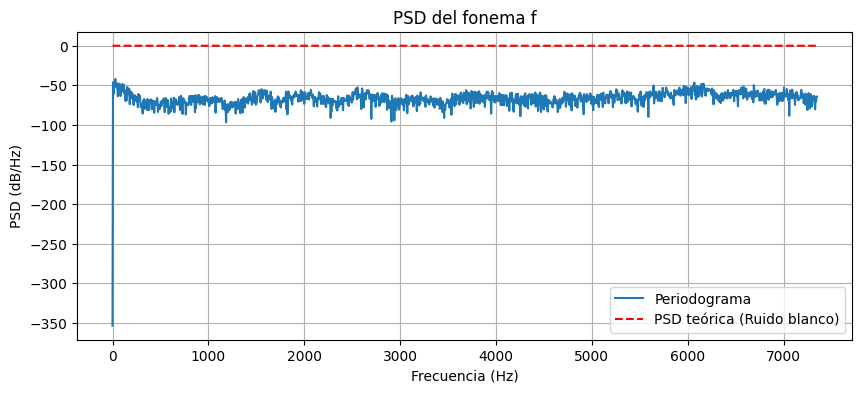

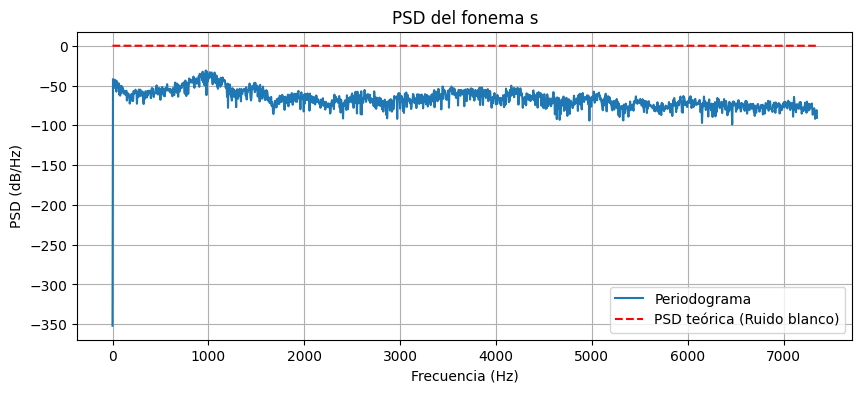

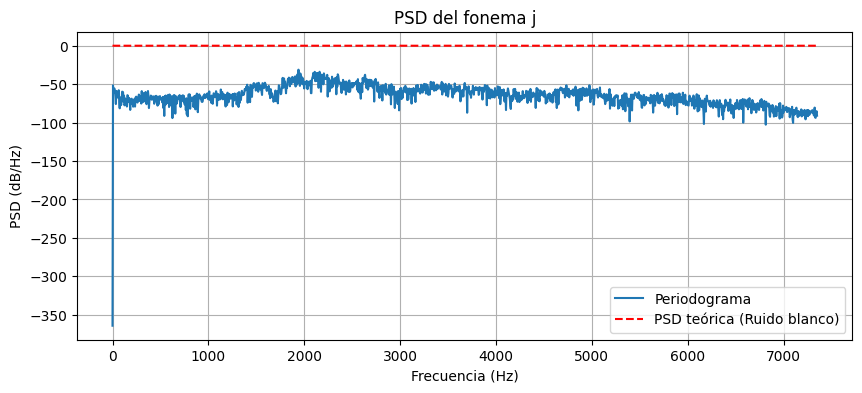

In [ ]:
for i, tramo in enumerate(tramos):
    fonema = fonemas[i]
    f, Pxx = periodogram(tramo, fs, scaling='density')

    plt.figure(figsize=(10, 4))
    plt.plot(f, 10 * np.log10(Pxx), label="Periodograma")

    if fonema in ['f', 's', 'j', 'sh']:
        S_U = np.ones_like(f)
        plt.plot(f, 10 * np.log10(S_U), 'r--', label="PSD teórica (Ruido blanco)")
    else:
        f0 = 500 #pitch (AJUSTABLE)
        Su, f_pulsos = psd_pulsos(f0, N, fs)
        plt.plot(f_pulsos[:N//2], 10 * np.log10(Su[:N//2]), 'r--', label="PSD teórica (Tren de pulsos)")

    plt.title(f"PSD del fonema {fonema}")
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("PSD (dB/Hz)")
    plt.legend()
    plt.grid()
    plt.show()

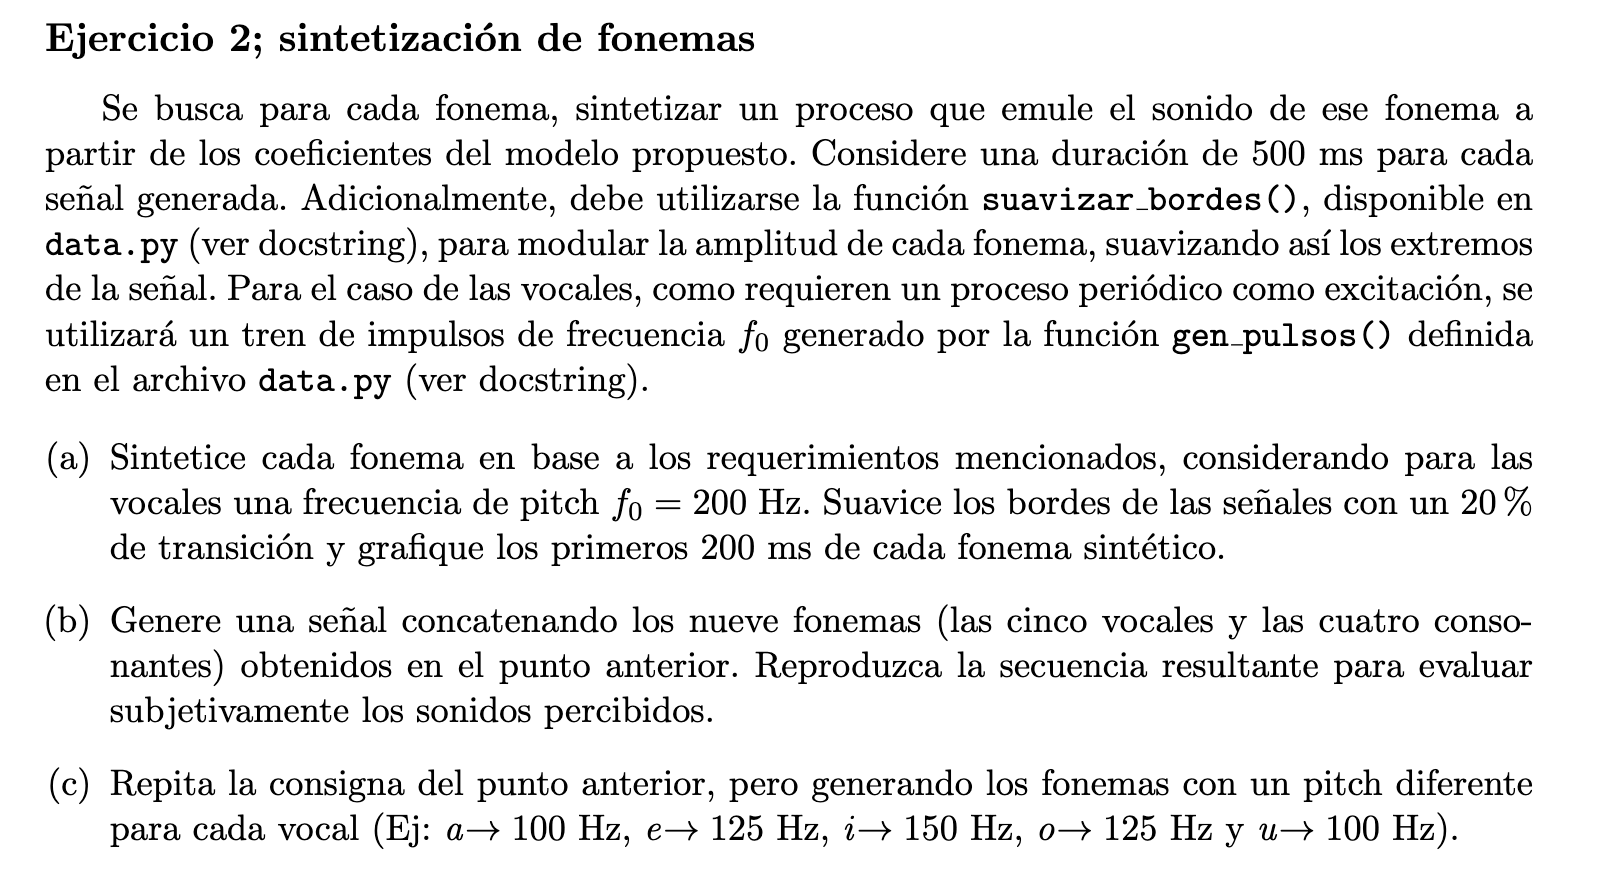

In [ ]:
#mismo que antes

def suavizar_bordes(x, fade=20):
    """
    Suaviza los bordes de una señal.
    x: señal original (array).
    fade: (float) porcentaje de transición en los bordes (0-50% del largo de x)
    retorna: versión suavizada de x
    """
    N = len(x)
    fade = max(1, min(fade, 50))  # Limita fade entre 1 y 50
    M = 2 * int(fade / 100 * N)
    v = np.hamming(M)
    fade_in = v[:M // 2]
    fade_out = v[M // 2:]
    window = np.concatenate([fade_in, np.ones(N - M), fade_out])
    s = window * x
    return s

def reproducir(audio, fs):
    """
    Reproducir audio usando soundevice
    audio: array con el contenido de la señal
    fs: freucencia de muestreo [Hz]
    """
    sd.play(audio, fs)
    sd.wait()

In [ ]:
#lo que queremos "copiar"
for i in audios:
    reproducir(i, fs)

In [ ]:
duracion_fonema = 0.5
N = int(duracion_fonema * fs) #piso val
f0_vocales = 200

print(fonemas[:5])

['a', 'e', 'i', 'o', 'u']


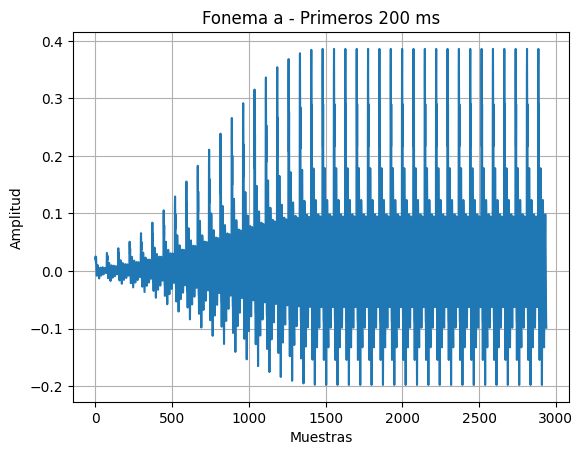

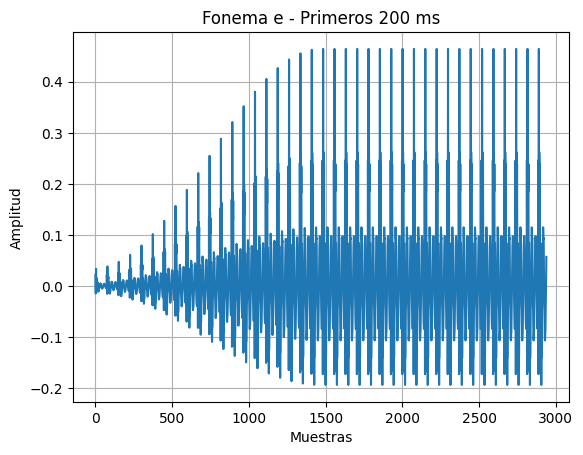

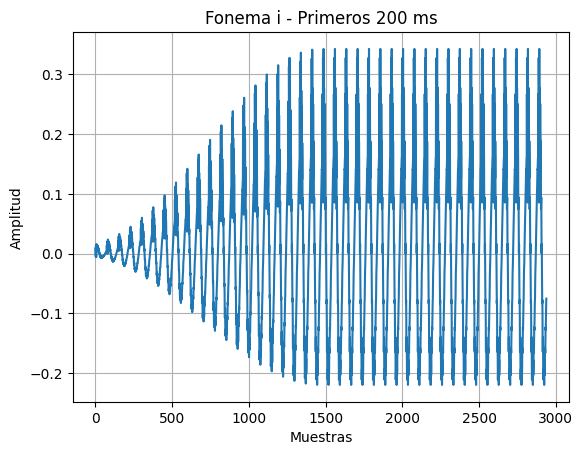

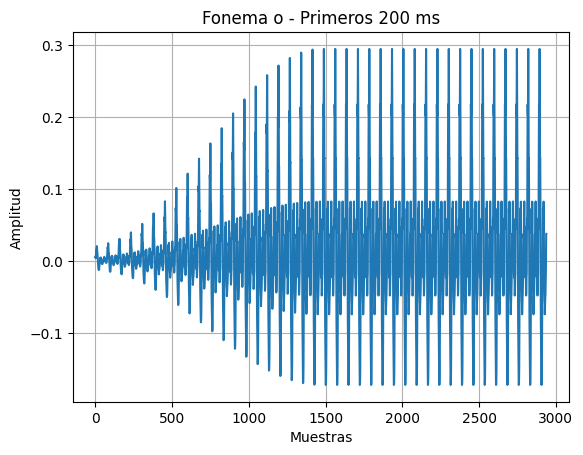

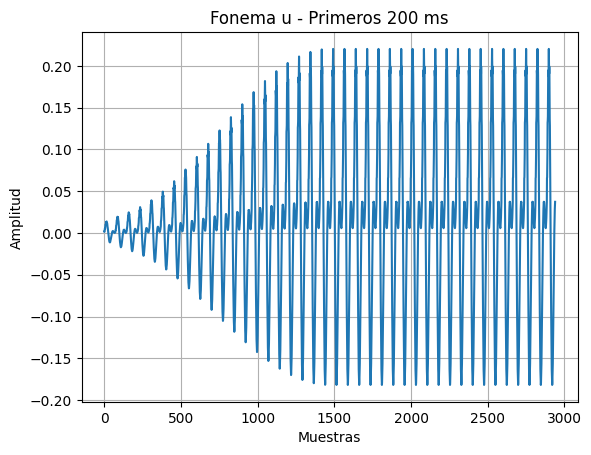

In [ ]:
#a)
señales_vocales = {}

for vocal in fonemas[:5]:
    excitacion = gen_pulsos(f0_vocales, N, fs)

    b = np.array(coef_b[vocal])
    a = np.array([1.0] + [-coef for coef in coef_a[vocal]])
    
    #modelo AR
    señal = lfilter(b, a, excitacion)
    señal = suavizar_bordes(señal)
    señales_vocales[vocal] = señal
    
    plt.figure()
    plt.plot(señal[:int(0.2 * fs)])
    plt.title(f"Fonema {vocal} - Primeros 200 ms")
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud")
    plt.grid()
    plt.show()

for i in señales_vocales:
    reproducir(señales_vocales[i], fs) #suenan igual :)))

In [ ]:
#b) (formalmente, lo mismo q ya probamos antes)
señal_concatenada = np.concatenate(list(señales_vocales.values()))
sd.play(señal_concatenada, fs)